In [16]:
import sys
import argparse
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import os

from keras.preprocessing import image
from keras.models import load_model
from keras.applications.inception_v3 import preprocess_input

In [2]:
target_size = (299, 299) #fixed size for InceptionV3 architecture


def predict(model, img, target_size):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
        target_size: (w,h) tuple
    Returns:
        list of predicted labels and their probabilities
    """
    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(image, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        image: PIL image
        preds: list of predicted labels and their probabilities
    """
    plt.imshow(image)
    plt.axis('off')

    plt.figure()
    labels = ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
    plt.barh(np.arange(len(labels)), preds, alpha=0.5)
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel('Probability')
    plt.xlim(0,1.01)
    plt.tight_layout()
    plt.show()

In [7]:
model = load_model("full_model.model")

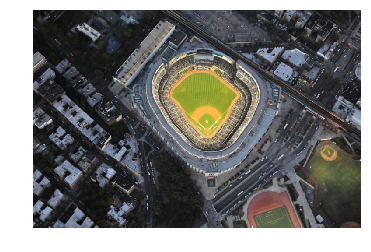

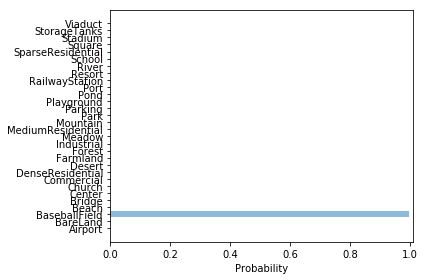

In [14]:
img = Image.open("C:\\Users\\Pedro\\Desktop\\test_image.jpg")
preds = predict(model, img, target_size)
plot_preds(img, preds)

In [40]:
deep_list = [list(map(lambda file: os.path.join(x[0], file), x[2])) for x in os.walk("C:\\Users\\Pedro\\Downloads\\AID\\AID-split\\test") if x[1] == []]
test_images = [item for sublist in deep_list for item in sublist]

In [ ]:
for img in test_images:
    img = Image.open(img)
    preds = predict(model, img, target_size)
    plot_preds(img, preds)